# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **클러스터 내부 구조(Cluster Topology)와 리덕션**

**클러스터 내부 구조(Cluster Topology)**

스파크(Spark) 클러스터의 내부 구조에 대해서 알아볼 것이다.

스파크는 마스터(Master)와 워커(Worker)의 구조로 구성되어 있다.

스파크를 사용하며 잊지 말아야 할 점은,
항상 데이터가 여러 곳에 분산 되어 있다는 것과

같은 연산이더라도 여러 노드에 걸쳐 실행된다는 점이다.

**스파크의 구조**

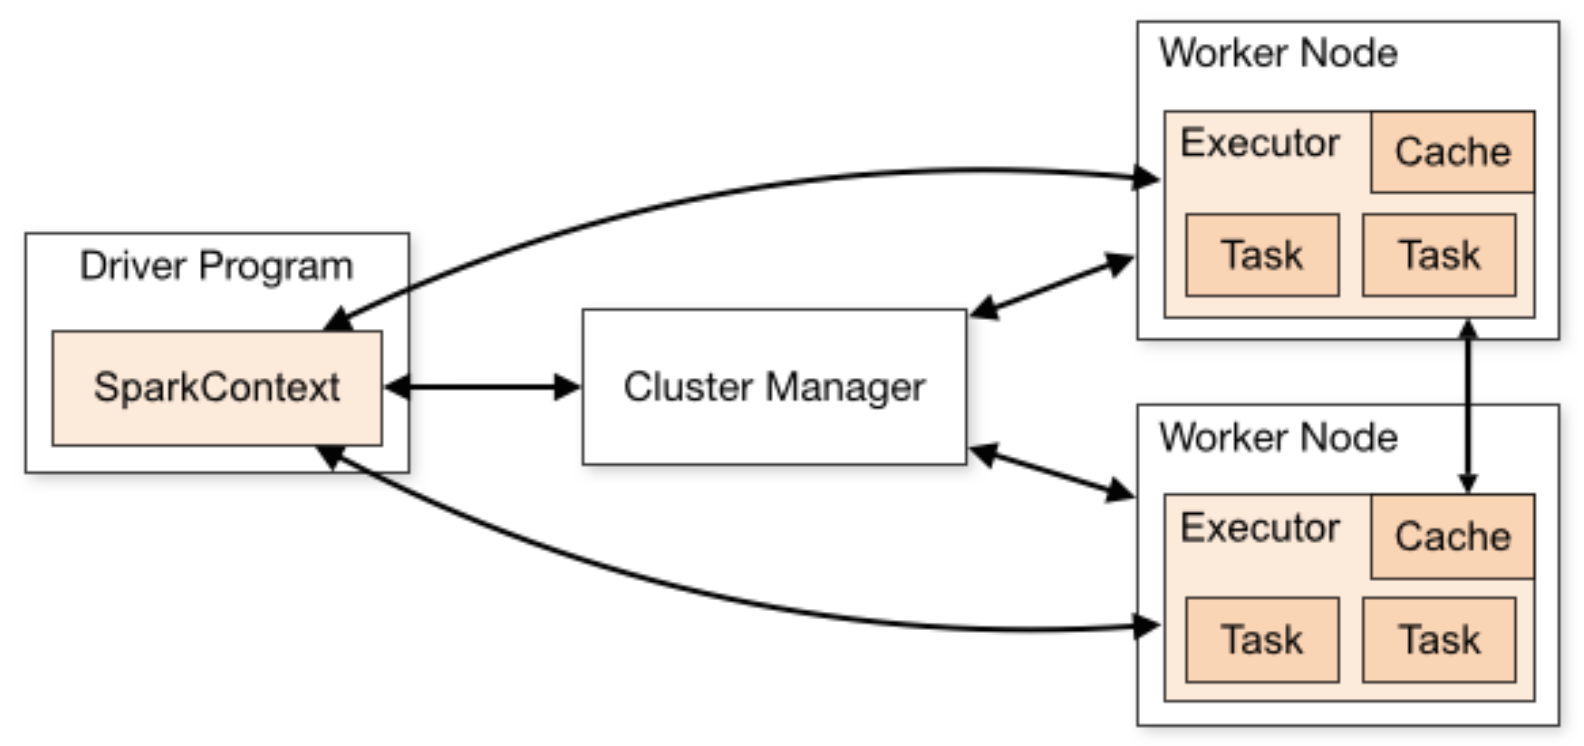

스파크는 마스터-워커 구조로 실행된다.

작업을 관장하는 드라이버와 실제 작업이 동작하는 익스큐터로 구성된다.

드라이버는 스파크 컨텍스트 객체를 생성하여 클러스터 매니저와 통신하면서 클러스터의 자원 관리를 지원하고, 애플리케이션의 라이프 사이클을 관리한다.

**드라이버(Driver) 프로그램**

드라이버 프로그램은 스파크 컨텍스트이며, 새로운 RDD를 생성한다.

개발할 때 드라이버 프로그램을 중심으로 사용하며, 드라이브 프로그램이 노드들에게 연산 작업을 보낸다.

드라이버 프로그램은 개발자나 사용자가 프로그램과 상호 작용을 할 수 있게 해주는 노드이다.

실제 작업은 워커 노드에서 일어나며, 드라이버 프로그램은 작업을 직접 수행하지 않고 조직한다.

드라이버 프로그램과 워커 노드는 중간의 클러스터 매니저로 연결한다.

클러스터 매니저는 실행되는 작업의 스케쥴링과 클러스터 전반의 자원 관리를 담당한다.

유명한 클러스터로 얀과 메소스 등이 있다.

마스터 노드인 드라이버 프로그램은 모든 프로세스를 조직하는데 쓰인다.

메인 프로세스를 수행하고 스파크 컨텍스트를 생성하여 RDD를 생성한다.

트랜스포메이션과 액션을 저장하거나 워커노드에 전송하는데 쓰인다.

**익스큐터(Executor)**

워크 노드 내부에 보이는 익스큐터가 연산을 수행하고 데이터 저장하여 드라이버 프로그램으로 보낸다.

테스크를 실행하고 그렇게 나온 연산 결과를 드라이버 프로그램에 전송하는데, 연산을 하면서 필요한 저장 공간를 제공하는 캐시를 갖고있다.

**실행 과정 요약**

드라이버 프로그램이 스파크 컨텍스트에서 애플리케이션을 만든다.

스파크 컨텍스트가 클러스터 매니저에 연결하고 자원을 할당한다.

클러스터 매니저가 노드들의 익스큐터를 수집하고 연산을 수행해서 데이터를 저장한다.

스파크 컨텍스트가 익스큐터에게 실행 할 테스크를 전송한 다음 그렇게 실행 된 테스크는 결과값을 뱉고 다시 드라이브로 보낸다.

**리덕션(Reduction)**

리덕션 오퍼레이션은 요소들을 모아 하나로 합치는 작업이다.

많은 스파크의 연산들이 리덕션 오퍼레이션이다.

그 중 병렬, 분산된 환경에서의 리덕션 작업을 알아볼 것이다.

지금까지 트랜스포메이션과 액션, 지연 실행으로 성능 최적화, Cache()와 Persist(), 클러스터의 내부 구조에 대해 알아보았다.

주로 분산 환경의 트랜스포메이션이었으며, 변형을 적용시키는 작업들이었다.

map, flatMap, filter

그렇다면 분산된 환경에서의 액션에 대해 알아볼 것이다.

**리덕션이란?**

리덕션은 근접하는 요소들을 모아서 하나의 결과로 만드는 일이다.

대부분의 액션이 리덕션이라고 볼 수 있다.

파일 저장, collect() 등과 같이 리덕션이 아닌 액션도 있다.

**병렬에서의 리덕션**

**병렬 처리가 가능한 경우**

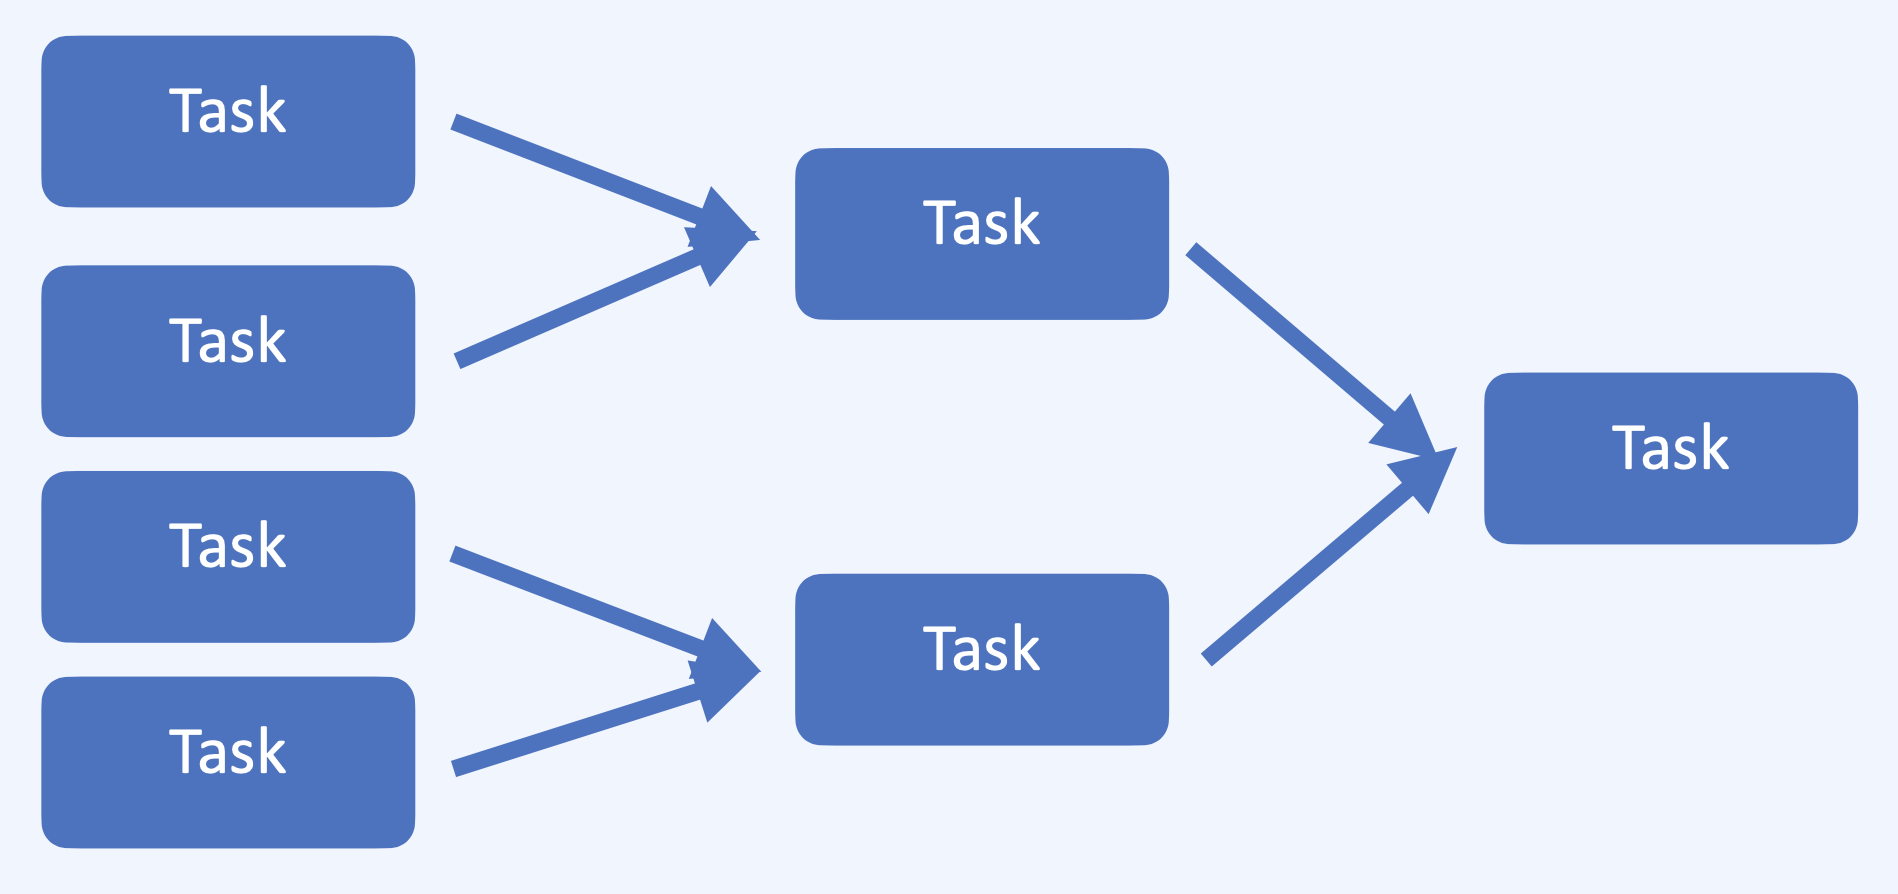

병렬 처리가 가능하려면 두 개 요소를 모아 하나의 값으로 합치는 성질이 필요하다.

여러 파티션에서 결과값을 만들고 합치게 되면 여러 작업을 동시에 할 수 있다.

각 테스크나 파티션은 서로에 대해 독립적이어야한다.

**병렬 처리가 불가능한 경우**

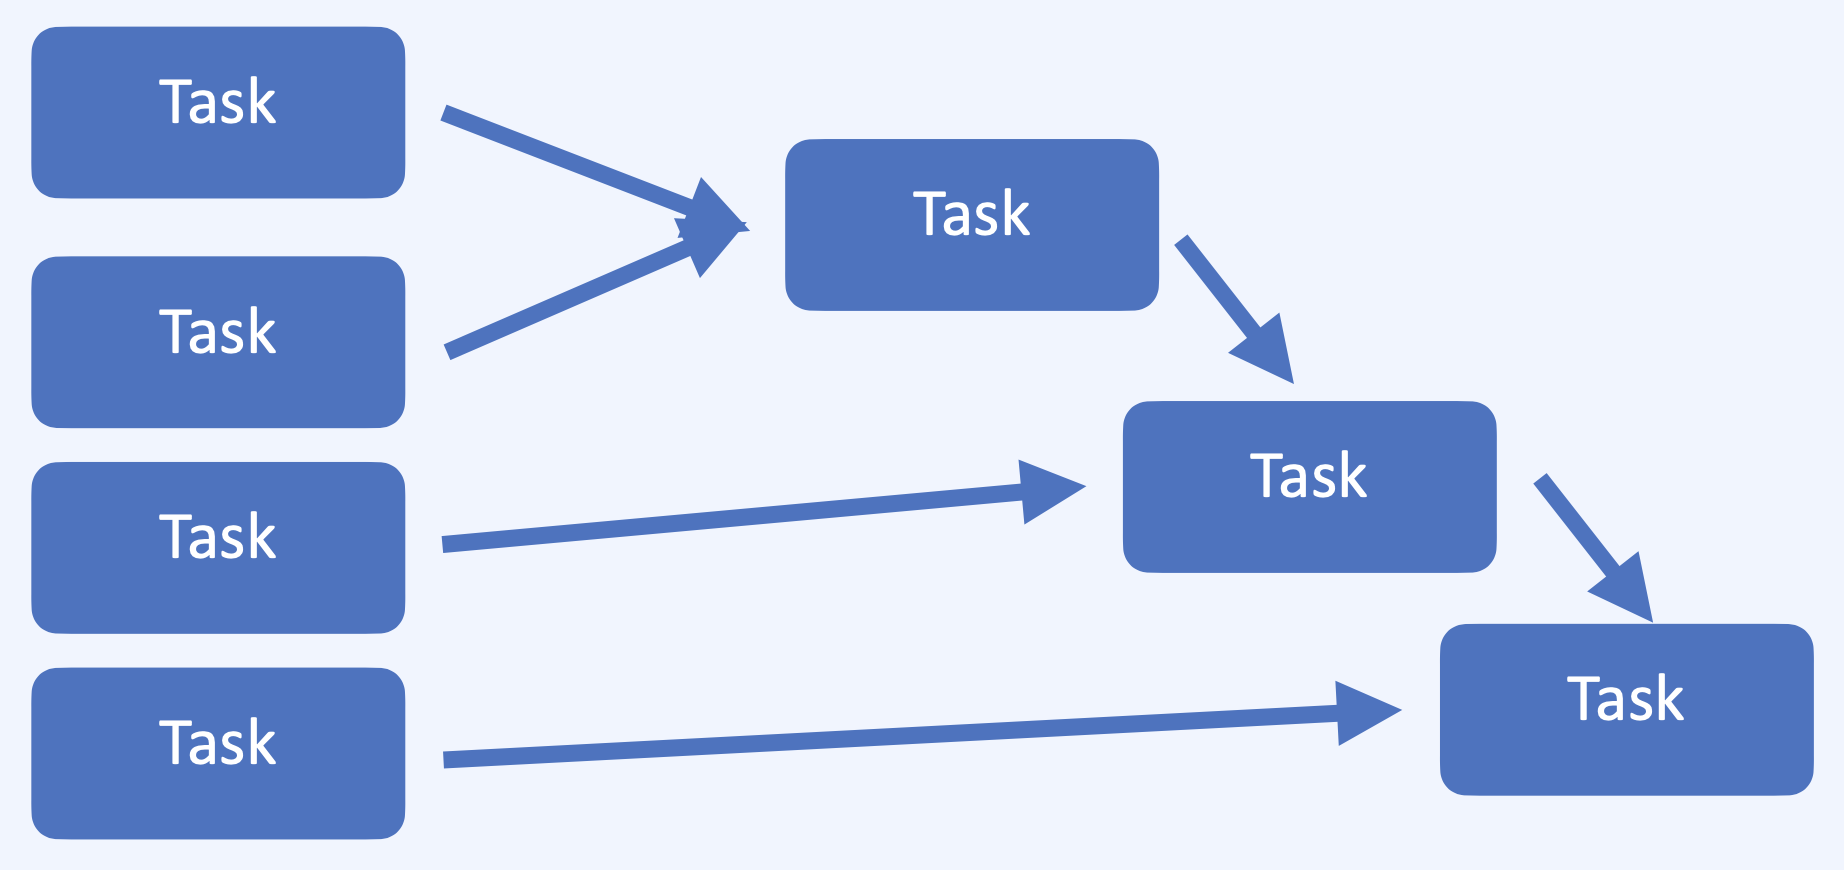

파티션이 다른 파티션의 결과값에 의존한다면 한 테스크가 전 테스크를 기다려야하기 때문에 동시에 실행하지 못하여 병렬 처리가 힘들다.

분산 처리를 하는 의미가 없어지며 어차피 순서대로 처리할거면 컴퓨터 하나로도 가능하다.

# **대표적인 리덕션 액션**

**Reduce**

사용자가 지정하는 함수를 받아서 여러개의 값을 하나로 줄여주는 일을 한다.

In [5]:
from operator import add
from pyspark import SparkConf, SparkContext

sc = SparkContext()

sc.parallelize([1, 2, 3, 4, 5]).reduce(add)

15

In [10]:
sc.parallelize([1, 2, 3, 4]).reduce(lambda x, y: (x*2)+y), sc.parallelize([1, 2, 3, 4],2).reduce(lambda x, y: (x*2)+y)

(18, 18)

In [9]:
sc.parallelize([1, 2, 3, 4],4).reduce(lambda x, y: (x*2)+y)

26

분산된 파티션들의 연산과 합치는 부분을 나눠서 생각해보면 계산식이 아래와 같기 때문이다.

(1,2,3,4) -> ((12+2)2+3)*2+4 = 26

(1,2) (3,4) -> ((12+2)2 + (3*2)+4) = 18

파티션이 어떻게 나뉠 지 프로그래머가 
정확하게 알기 어렵기 때문에 연산의 순서와 상관 없이 결과값을 보장하려면 아래와 같은 방법들이 필요하다.

교환법칙 (ab = ba)

결합법칙 (ab)c = a(bc)

**Fold** 
Reduce와 비슷하지만 다른 점은, zeroValue가 들어간다는 점이다

In [11]:
sc.parallelize([1, 2, 3, 4, 5]).fold(0, add)

15

In [19]:
rdd = sc.parallelize([2, 3, 4], 4)
rdd.reduce(lambda x, y: x*y) # (2*3*4) = 24

24

In [13]:
rdd.fold(1, lambda x, y: x*y) #(1*2*3*4) = 24

24

In [14]:
rdd.reduce(lambda x, y: x+y) #0 + 2 + 3 + 4 = 9

9

In [15]:
rdd.fold(1, lambda x, y: x+y) #(1+1) + (1+2) + (1+3) + (1+4) = 14

14

곱하기로 할 때 시작점을 0으로 한다면 결과값이 0으로 나올 것이다.

함수를 더하기로 한다면, 코드 내 주석과 같이 각 파티션의 시작값이 1로 설정되기 때문에 14가 전시된다.

**GroupBy**
기준 함수를 받아 범주화를 해주는 액션이다.

In [16]:
rdd = sc.parallelize([1, 1, 2, 3, 5, 8])
res = rdd.groupBy(lambda x: x % 2).collect()
sorted([(x, sorted(y)) for (x, y) in res])


[(0, [2, 8]), (1, [1, 1, 3, 5])]

**Aggregate**

RDD 데이터 타입과 액션 결과 타입이 다를 경우에 사용한다.

파티션 단위의 연산 결과를 합치는 과정을 거친다.

RDD.aggregate(zeroValue, seqOp, combOp)

zeroValue: 각 파티션에서 누적할 시작 값

seqOp: 타입 변경 함수

combOp: 합치는 함수

In [21]:
seqOp = (lambda x, y: (x[0] + y, x[1] + 1))
combOp = (lambda x, y: (x[0] + y[0], x[1]+ y[1]))
sc.parallelize([1, 2, 3, 4]).aggregate((0, 0), seqOp, combOp)

(10, 4)

In [22]:
sc.parallelize([]).aggregate((0, 0), seqOp, combOp)

(0, 0)

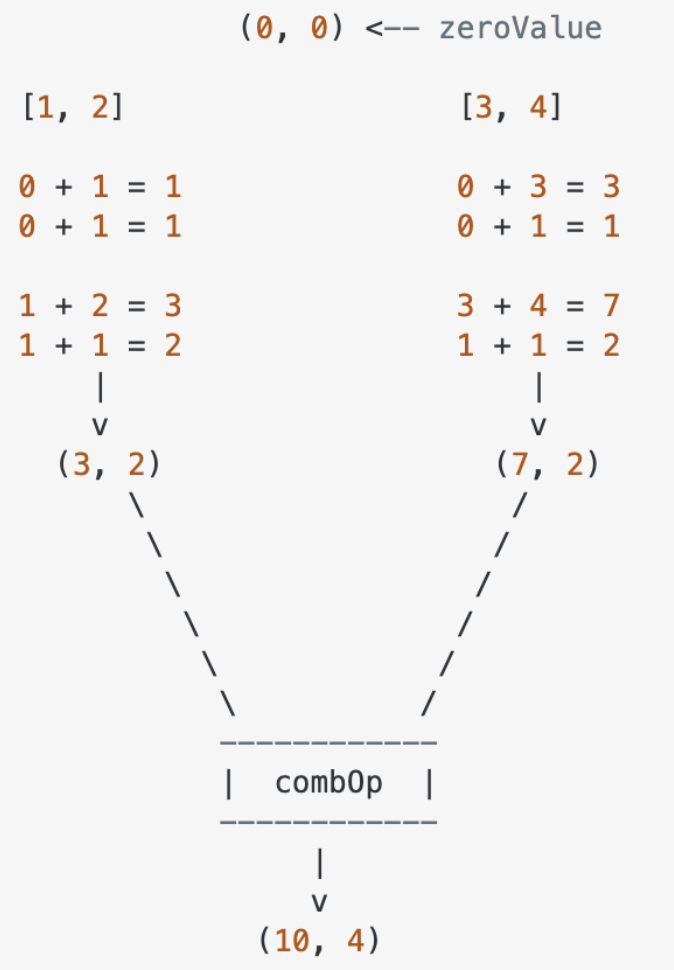

x[0] = 0 , x[1] = 0 (zeroValue)

x[0]+y=(0+1),x[1]+1=(0+1) ->(1,1)

x[0]+y=(1+2),x[1]+1=(1+1)->(3,2)

x[0] = 0 , x[1] = 0 (zeroValue)

x[0]+y=(0+3),x[1]+1=(0+1) ->(3,1)

x[0]+y=(3+4),x[1]+1=(1+1)->(7,2)

Aggregate는 가장 많이 쓰이는 리덕션 액션이다.

대부분의 데이터 작업은 크고 복잡한 데이터 타입에서 정제된 데이터로 만드는 과정이기 때문이다.

이 외에도 여러가지 오퍼레이션이 존재한다.